In [1]:
import os, sys
import general_config 
print(general_config.ROOTDIR)
sys.path.append(general_config.ROOTDIR)

import torch
import torch.nn as nn
import numpy as np
from model.adjusted_resnet34 import AdjResnet34

D:/Desktop@D/xai_basic


In [2]:
from captum.attr import IntegratedGradients ,GradientShap, Saliency, Occlusion, DeepLiftShap, InputXGradient
from captum.attr import DeepLift, GuidedBackprop, GuidedGradCam, Deconvolution, FeatureAblation 

Note that they distinguish between "attribution" and "layer attribution"

The first question we can ask is which of the features were actually important to the model to reach this decision? This is the first main component of Captum, the ability to obtain Feature Attributions. 

"Layer attributions allow us to understand the importance of all the neurons in the output of a particular layer. For this example, we will be using Layer Conductance, one of the Layer Attribution methods in Captum, which is an extension of Integrated Gradients applied to hidden neurons". From resnet with (224,224) images, we see that assigning layer attribution to self.backbone.conv1 (self.backbone is the resnet) yields attribution values of shape (1,112,112). Indeed, conv1 has kernel size 3 which does half the size of the img; i.e. the output of layer attribution is evaluated on the output of conv1 (some collapse the values to 1 channel, but others keep the channel sizes).

In [3]:
import matplotlib.pyplot as plt
def create_comparison(x,heatmap, vmax=1.,vmin=1.,this_title=None):
    # x is torch tensor like (C,H,W)
    plt.figure(figsize=(12,12))
    counter = 1
    x1 = x.cpu().clone().detach().numpy().transpose(1,2,0)
    h1 = heatmap.cpu().clone().detach().numpy().transpose(1,2,0)
    for i in range(4):            
        plt.gcf().add_subplot(1,4,counter)
        if i == 0:
            plt.gca().imshow(x1)
            plt.title('%s'%(str(this_title)))
        else:
            # 3 channels of the heatmaps
            # print('h1:',np.max(h1),np.min(h1), h1.shape)
            plt.gca().imshow(h1[:,:,i-1], cmap='bwr', vmax=vmax,vmin=vmin) 
        counter += 1
    plt.show()

In [4]:
N = 2
x = torch.tensor(np.random.uniform(0,1,size=(N,3,224,224))).to(torch.float)
x[:2,1,100:120,100:120] = x[:2,1,100:120,100:120]* 0. + 1.
y0 = [0,0,1,1] # np.random.randint(2,size=(N,))
print(y0)

[0, 0, 1, 1]


In [5]:
this_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    

net = AdjResnet34()
net.readjust(verbose=999)
net.to(device=this_device)
x = x.to(device=this_device)

y = net(x)
print('y.shape:',y.shape)


DOUBLE CHECK
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torch.nn.modules.container.Sequential'>
   <class 'model.torchvision_resnet_components_revised.BasicBlockRevised'>
   <class 'model.torchvision_resnet_components_revised.BasicBlockRevised'>
   <class 'model.torchvision_resnet_components_revised.BasicBlockRevised'>
<class 'torch.nn.modules.container.Sequential'>
   <class 'model.torchvision_resnet_components_revised.BasicBlockRevised'>
   <class 'model.torchvision_resnet_components_revised.BasicBlockRevised'>
   <class 'model.torchvision_resnet_components_revised.BasicBlockRevised'>
   <class 'model.torchvision_resnet_components_revised.BasicBlockRevised'>
<class 'torch.nn.modules.container.Sequential'>
   <class 'model.torchvision_resnet_components_revised.BasicBlockRevised'>
   <class 'model.torchvision_resnet_components_revised.BasicBlockR

In [6]:
def quick_setup(attrmodel, x,y, option=None):
    x.requires_grad=True
    net.zero_grad()
    for i in range(len(x)): # iterate thru batch number (otherwise too memory consuming)
        if option == 'GradientShap':
            baseline_dist = torch.randn(x.shape) * 0.001
            attr = attrmodel.attribute(x[i:i+1], target = y0[i], baselines=baseline_dist)
        elif option == 'DeepLifShap':
            baseline_dist = torch.randn(x.shape) * 0.001
            attr = attrmodel.attribute(x[i:i+1], target = y0[i], baselines=baseline_dist)
        elif option == 'Occlusion':
            attr = attrmodel.attribute(x[i:i+1], target = y0[i], sliding_window_shapes=(3,40, 40),strides = (3, 20,20))
        elif option == 'FeatureAblation':
            feature_mask = torch.tensor(0.1*np.ones((3,64,64))).to(torch.int64)
            attr = attrmodel.attribute(x[i:i+1], target = y0[i], feature_mask=feature_mask)
        else:
            attr = attrmodel.attribute(x[i:i+1], target = y0[i])

        this_min, this_max = torch.max(attr).item(), torch.min(attr).item()
        heatmap_magnitude = np.max((np.abs(this_min), np.abs(this_max)))
        print('attr.shape:%s, max:%s, min:%s'%(str(attr.shape), str(this_max),str(this_min)))
        this_title = 'hmag:%s'%(str(np.round(heatmap_magnitude,5)))
        create_comparison(x[i].cpu(),heatmap=attr[0], vmax=heatmap_magnitude,vmin=-heatmap_magnitude,
                          this_title=this_title) # grads still in (1,C,H,W)

# Part 1. 
The following are categorized under Attribution

attr.shape:torch.Size([1, 3, 224, 224]), max:-0.036742568016052246, min:0.02455160580575466


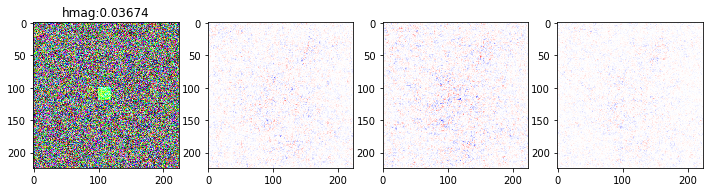

attr.shape:torch.Size([1, 3, 224, 224]), max:-0.026090625673532486, min:0.03236835077404976


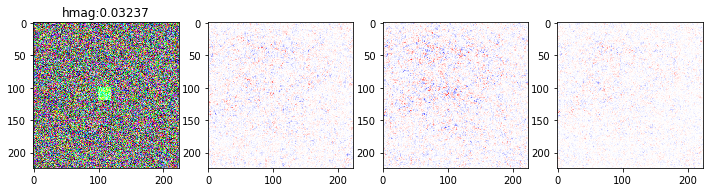

In [7]:
## 1.
net.zero_grad()
quick_setup(IntegratedGradients(net), x.clone().detach(), y0)

## 2.
net.zero_grad()
quick_setup(Saliency(net), x.clone().detach(), y0)

## 3.
net.zero_grad()
quick_setup(DeepLift(net), x.clone().detach(), y0)

## 4.
net.zero_grad()
quick_setup(DeepLiftShap(net), x.clone().detach(), y0, option='DeepLifShap')

## 5.
net.zero_grad()
quick_setup(GradientShap(net), x.clone().detach(), y0, option='GradientShap')

## 6.
net.zero_grad()
quick_setup(InputXGradient(net), x.clone().detach(), y0, )

## 7.
net.zero_grad()
quick_setup(GuidedBackprop(net), x.clone().detach(), y0, )

## 8.
net.zero_grad() 
quick_setup(GuidedGradCam(net, net.backbone.conv1), x.clone().detach(), y0, )

## 9.
net.zero_grad()
quick_setup(Deconvolution(net), x.clone().detach(), y0, )

In [8]:
## 10. 
print('Not implemented. Feature ablation requires masks that are difficult to set or, if predefined, seems to beat the original objective')

Not implemented. Feature ablation requires masks that are difficult to set or, if predefined, seems to beat the original objective


## 11.
net.zero_grad()
quick_setup(Occlusion(net), x.clone().detach(), y0, option='Occlusion')

# part 2.
The following are categorized under layered attribution

In [9]:
def create_comparison2(x,heatmap, vmax=1.,vmin=1.,this_title=None):
    # x is torch tensor like (C,H,W)
    plt.figure(figsize=(12,12))
    counter = 1
    x1 = x.cpu().clone().detach().numpy().transpose(1,2,0)
    h1 = heatmap.cpu().clone().detach().numpy().transpose(1,2,0)
    for i in range(2):            
        plt.gcf().add_subplot(1,4,counter)
        if i == 0:
            plt.gca().imshow(x1)
            plt.title('%s'%(str(this_title)))
        else:
            # 1 channel of layer heatmaps
            # print('h1:',np.max(h1),np.min(h1), h1.shape)
            plt.gca().imshow(h1[:,:,i-1], cmap='bwr', vmax=vmax,vmin=vmin) 
        counter += 1
    plt.show()

In [10]:
def quick_setup2(attrmodel, x,y, option=None):
    x.requires_grad=True
    with torch.cuda.device(0):
        net.zero_grad()
        for i in range(len(x)): # iterate thru batch number (otherwise too memory consuming)
            attr = attrmodel.attribute(x[i:i+1], target = y0[i])
            this_min, this_max = torch.max(attr).item(), torch.min(attr).item()
            heatmap_magnitude = np.max((np.abs(this_min), np.abs(this_max)))
            print('attr.shape:%s, max:%s, min:%s'%(str(attr.shape), str(this_max),str(this_min)))
            this_title = 'hmag:%s'%(str(np.round(heatmap_magnitude,5)))
            create_comparison2(x[i],heatmap=attr[0], vmax=heatmap_magnitude,vmin=-heatmap_magnitude,
                              this_title=this_title) # grads still in (1,C,H,W)

In [11]:
from captum.attr import LayerGradCam, LayerDeepLift

# 12.
net.zero_grad()
quick_setup2( LayerGradCam(net,  net.backbone.conv1), x.clone().detach(), y0)

attr.shape:torch.Size([1, 64, 112, 112]), max:-0.006508264224976301, min:0.0072760372422635555


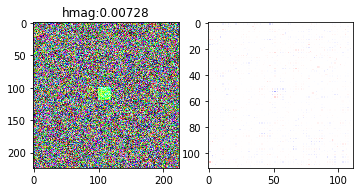

attr.shape:torch.Size([1, 64, 112, 112]), max:-0.007204369641840458, min:0.00731080025434494


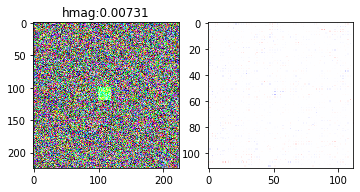

In [12]:
# 13.
net.zero_grad() 
quick_setup2(LayerDeepLift(net, net.backbone.conv1), x.clone().detach(), y0)